In [1]:
#Desabilita logs e mantém apenas logs críticos (para evitar o libcuda ficar me avisando que a GPU tá funcionando)
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import scipy as spy
import keras
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
from keras.optimizers import Adam,RMSprop

2021-08-16 10:54:18.429351: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('datasets/winequality-white.csv', sep = ',')
df.head()        

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Olhando abaixo, não temos nenhum valor N/A, então não precisamos tratar isso.

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
print(len(df))


4898


In [6]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

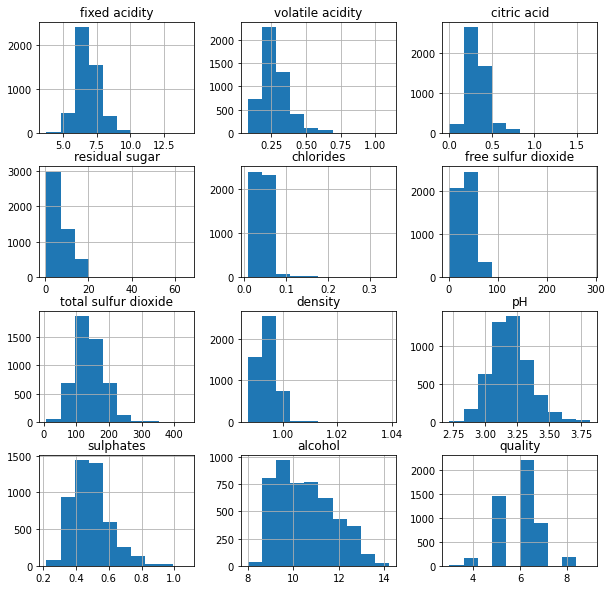

In [7]:
df.hist(figsize = (10, 10))

<h2> SMOTE </h2>

Podemos ver acima que temos um desbalanceamento na quantidade de amostras. Temos muitas regulares e poucas ruins e ótimas. Vamos usar uma técnica chamada SMOTE que consiste em fazer o oversampling das amostras minoritária}s, deixando assim o dataset balanceado. Essa técnica foi descrita no artigo.

In [8]:
X=df.drop(columns=['quality'])
y=df['quality']

In [9]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)
X, y = oversample.fit_resample(X, y)

Vemos abaixo que as classificações agora estão igualmente distribuiídas:

In [10]:
print(y.dtypes)
print(y.count())
y.value_counts()

int64
15386


6    2198
5    2198
7    2198
8    2198
4    2198
3    2198
9    2198
Name: quality, dtype: int64

In [11]:
y[y<=4] = 0
y[((y>=5) & (y<=7))] = 1
y[y>=8] = 2    
y.value_counts()

1    6594
2    4396
0    4396
Name: quality, dtype: int64

Substituindo as faixas de qualidade por 0 (baixa), 1 (média) e 2 (alta):


In [12]:
df = pd.concat([X, y.reindex(X.index)], axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


Pronto, agora temos todas as amostras em quantias iguais.

<h2> Hot encoding </h2>

Primeiro vamos separar a qualificações que vão de 6 à 9 (no caso desse dataset) em 0 1 e 2. Sendo 0 a qualidade mais baixa, 1 a média e 2 a alta, como vamos configurar para o hot encoding posteriormente. 

No trecho de código abaixo, vou converter as varíaveis categóricas (0 1 e 2) em uma tabela. Essa tabela tem 3 colunas, onde cada uma corresponde à uma das classificações possíveis. Sempre apenas um dos items dessa coluna vai ser 1 e o resto 0. O nosso modelo ira tentar prever o valor dessas 3 colunas para assim prever a qualidade do vinho.

In [13]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['quality'])
df = one_hot_encoded_data.rename(columns={'quality_0': 'baixa', 'quality_1': 'media', 'quality_2': 'alta'})
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,baixa,media,alta
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,1,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,1,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,1,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,1,0


In [14]:
y = df[['baixa','media', 'alta']]

Matriz de correlação:

<AxesSubplot:>

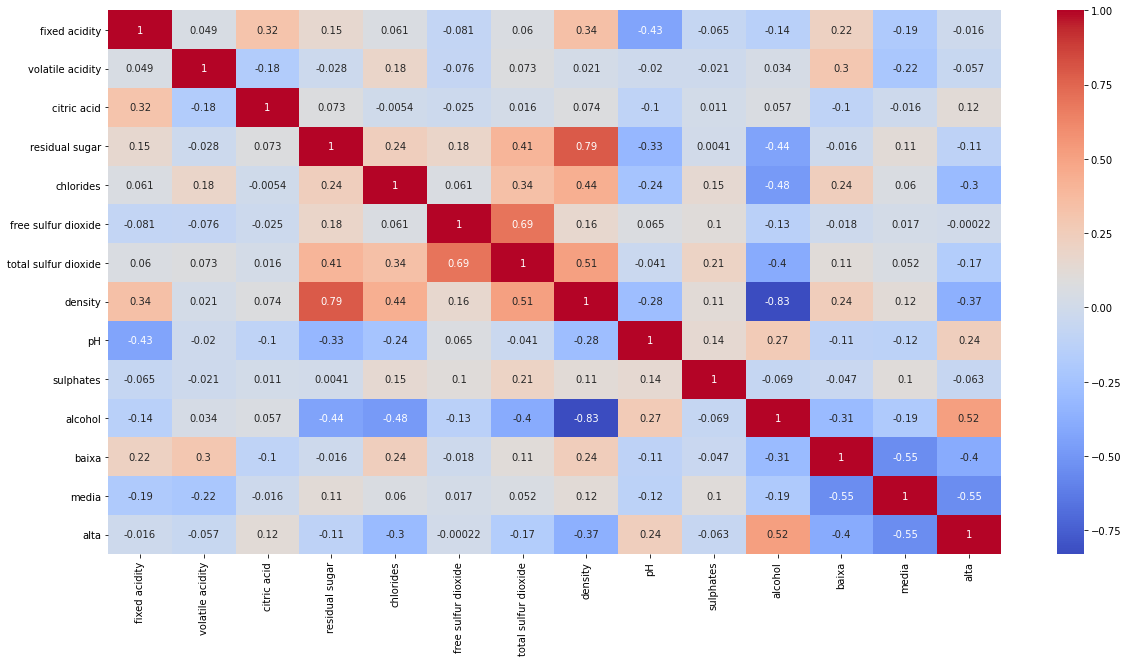

In [15]:
corr=df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(corr,annot=True, cmap='coolwarm')

<h1>Separando o dataset de treinamento e o de predição</h1>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=21)
print('Formato do dataset de treinamento Xs:{}'.format(X_train.shape))
print('Formato do datasett de teste Xs:{}'.format(X_test.shape))
print('Formato do dataset de treino y:{}'.format(y_train.shape))
print('Formato do dataset de test y:{}'.format(y_test.shape))

Formato do dataset de treinamento Xs:(12308, 11)
Formato do datasett de teste Xs:(3078, 11)
Formato do dataset de treino y:(12308, 3)
Formato do dataset de test y:(3078, 3)


<h1> Construção do modelo </h1>

O artigo utilizou relu e tanh. Aqui abaixo vamos usar relu.

In [17]:
dimension = X_train.shape[1]
from keras import backend as K
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim = dimension,  activation='relu'))
    model.add(Dense(7, input_dim = dimension,  activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 24        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


2021-08-16 10:54:21.051167: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 10:54:21.084328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 10:54:21.084577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0c:00.0 name: NVIDIA GeForce GTX 660 Ti computeCapability: 3.0
coreClock: 1.0715GHz coreCount: 7 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 134.29GiB/s
2021-08-16 10:54:21.084598: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 10:54:21.086290: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 10:54:21.086377: I tensorflow/stream_executor/p

In [18]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=10)

Epoch 1/20


2021-08-16 10:54:21.162763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 10:54:21.163044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593305000 Hz


1231/1231 [==============================] - 1s 626us/step - loss: 1.7914 - accuracy: 0.4266 - val_loss: 1.0598 - val_accuracy: 0.4795
Epoch 2/20
1231/1231 [==============================] - 1s 496us/step - loss: 1.0377 - accuracy: 0.5019 - val_loss: 1.0239 - val_accuracy: 0.5120
Epoch 3/20
1231/1231 [==============================] - 1s 484us/step - loss: 0.9892 - accuracy: 0.5148 - val_loss: 0.9605 - val_accuracy: 0.5097
Epoch 4/20
1231/1231 [==============================] - 1s 476us/step - loss: 0.9120 - accuracy: 0.5263 - val_loss: 0.8702 - val_accuracy: 0.5227
Epoch 5/20
1231/1231 [==============================] - 1s 469us/step - loss: 0.8407 - accuracy: 0.5885 - val_loss: 0.8173 - val_accuracy: 0.5812
Epoch 6/20
1231/1231 [==============================] - 1s 488us/step - loss: 0.8086 - accuracy: 0.6040 - val_loss: 0.8412 - val_accuracy: 0.5747
Epoch 7/20
1231/1231 [==============================] - 1s 473us/step - loss: 0.7969 - accuracy: 0.6082 - val_loss: 0.7896 - val_accura

<h2>avaliação do resultado: </h2>

In [19]:
y_pred = model.predict(X_test)
def max_probs(array):
    parsed_pred = np.empty((0,3))
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = np.zeros((3,))
        x[idx_max] = 1
        array[idx] = x

max_probs(y_pred)


In [20]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr=multilabel_confusion_matrix(y_test, y_pred)

In [21]:
C0 = vis_arr[0]
C1 = vis_arr[1]
C2 = vis_arr[2]
Accuracy_C0 = (C0[0,0] + C0[1,1])/C0.sum() 
Accuracy_C1 = (C1[0,0] + C1[1,1])/C1.sum()
Accuracy_C2 = (C2[0,0] + C2[1,1])/C0.sum() 

In [22]:
labels = ['baixa', 'média', 'alta']

In [23]:

import seaborn as sns

def print_confusion_matrix(multilabel_confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        multilabel_confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

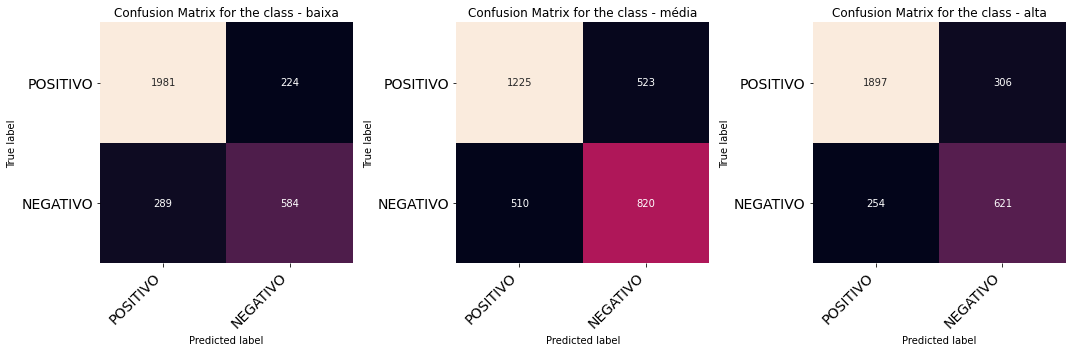

In [24]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["POSITIVO", "NEGATIVO"])
    
fig.tight_layout()
plt.show()

Acurácia do nosso modelo por classe:

In [25]:
data =np.array([[ Accuracy_C0 ],[Accuracy_C1], [ Accuracy_C2]])
df1 = pd.DataFrame(data, columns=['Acurácia'])
df1

,Acurácia
0,0.833333
1,0.664392
2,0.818064
